In [1]:
import requests
import pandas as pd
from datetime import datetime
import time
import os

def get_alpha_vantage_data(api_key, symbol, data_type='TIME_SERIES_DAILY', 
                           outputsize='full', datatype='json', interval='5min',
                           time_period=20, series_type='close', save_csv=True):
    """
    Download financial data from Alpha Vantage API
    
    Parameters:
    -----------
    api_key : str
        Your Alpha Vantage API key
    symbol : str
        The ticker symbol of the security
    data_type : str
        The type of data to download. Options include:
        - 'TIME_SERIES_INTRADAY': Intraday time series
        - 'TIME_SERIES_DAILY': Daily time series
        - 'TIME_SERIES_WEEKLY': Weekly time series
        - 'TIME_SERIES_MONTHLY': Monthly time series
        - 'GLOBAL_QUOTE': Latest price and volume
        - 'TECHNICAL_INDICATOR': Technical indicators like RSI, MACD, etc.
        - 'EARNINGS': Company earnings data
        - 'OVERVIEW': Company overview
    outputsize : str
        'compact' returns the latest 100 data points, 'full' returns up to 20 years of data
    datatype : str
        'json' or 'csv' for the format of returned data
    interval : str
        Time interval between data points for intraday data (1min, 5min, 15min, 30min, 60min)
    time_period : int
        Number of data points used to calculate technical indicators
    series_type : str
        The price type to use for technical indicators (close, open, high, low)
    save_csv : bool
        Whether to save the data as a CSV file
        
    Returns:
    --------
    pandas.DataFrame: The requested financial data
    """
    
    # Base URL for Alpha Vantage API
    base_url = 'https://www.alphavantage.co/query?'
    
    # Build parameters based on data type
    params = {
        'apikey': api_key,
        'symbol': symbol,
        'datatype': datatype
    }
    
    # Add function-specific parameters
    if data_type == 'TIME_SERIES_INTRADAY':
        params['function'] = 'TIME_SERIES_INTRADAY'
        params['interval'] = interval
        params['outputsize'] = outputsize
    elif data_type == 'TIME_SERIES_DAILY':
        params['function'] = 'TIME_SERIES_DAILY'
        params['outputsize'] = outputsize
    elif data_type == 'TIME_SERIES_WEEKLY':
        params['function'] = 'TIME_SERIES_WEEKLY'
    elif data_type == 'TIME_SERIES_MONTHLY':
        params['function'] = 'TIME_SERIES_MONTHLY'
    elif data_type == 'GLOBAL_QUOTE':
        params['function'] = 'GLOBAL_QUOTE'
    elif data_type == 'TECHNICAL_INDICATOR':
        # This is a placeholder - you'd need to specify which indicator
        # For example, for RSI:
        params['function'] = 'RSI'
        params['time_period'] = time_period
        params['series_type'] = series_type
    elif data_type == 'EARNINGS':
        params['function'] = 'EARNINGS'
    elif data_type == 'OVERVIEW':
        params['function'] = 'OVERVIEW'
    
    # Make API request
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raise exception for HTTP errors
        
        data = response.json()
        
        # Check for error messages
        if 'Error Message' in data:
            print(f"Error: {data['Error Message']}")
            return None
        
        # Process data based on type
        if data_type in ['TIME_SERIES_INTRADAY', 'TIME_SERIES_DAILY', 
                         'TIME_SERIES_WEEKLY', 'TIME_SERIES_MONTHLY']:
            # Find the time series key in the response
            time_series_key = [key for key in data.keys() if 'Time Series' in key][0]
            
            # Convert to DataFrame
            df = pd.DataFrame.from_dict(data[time_series_key], orient='index')
            
            # Format column names
            df.columns = [col.split('. ')[1] for col in df.columns]
            
            # Convert values to numeric
            for col in df.columns:
                df[col] = pd.to_numeric(df[col])
            
            # Add date as a column and sort
            df.index = pd.to_datetime(df.index)
            df = df.sort_index()
            
        elif data_type == 'GLOBAL_QUOTE':
            df = pd.DataFrame([data['Global Quote']])
            
        elif data_type in ['TECHNICAL_INDICATOR']:
            # Process technical indicator data
            indicator_key = [key for key in data.keys() if 'Technical Analysis' in key][0]
            df = pd.DataFrame.from_dict(data[indicator_key], orient='index')
            df.index = pd.to_datetime(df.index)
            df = df.sort_index()
            
        elif data_type in ['EARNINGS', 'OVERVIEW']:
            # For fundamental data, simply convert to DataFrame
            df = pd.DataFrame([data])
            
        else:
            print(f"Unsupported data type: {data_type}")
            return None
        
        # Save to CSV if requested
        if save_csv:
            filename = f"{symbol}_{data_type}_{datetime.now().strftime('%Y%m%d')}.csv"
            df.to_csv(filename)
            print(f"Data saved to {filename}")
        
        return df
    
    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
        return None
    except KeyError as e:
        print(f"Data format error: {e}. This could be due to API limits being reached.")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

# Function to download data for multiple symbols
def download_multiple_symbols(api_key, symbols, data_type='TIME_SERIES_DAILY', **kwargs):
    """
    Download data for multiple symbols with rate limiting
    
    Parameters:
    -----------
    api_key : str
        Your Alpha Vantage API key
    symbols : list
        List of ticker symbols
    data_type : str
        Type of data to download
    **kwargs : 
        Additional arguments passed to get_alpha_vantage_data
        
    Returns:
    --------
    dict: Dictionary of DataFrames with symbols as keys
    """
    results = {}
    
    for i, symbol in enumerate(symbols):
        print(f"Downloading data for {symbol} ({i+1}/{len(symbols)})")
        
        # Get data
        df = get_alpha_vantage_data(api_key, symbol, data_type, **kwargs)
        
        if df is not None:
            results[symbol] = df
        
        # Rate limiting: wait 12 seconds between requests to stay within the
        # 5 requests per minute limit (adding a little buffer)
        if i < len(symbols) - 1:
            print("Waiting to avoid API rate limits...")
            time.sleep(12)
    
    return results

'/home/asabaal'

In [2]:
# Set your API key
import pandas as pd
api_key = pd.read_csv("/home/asabaal/api_keys/alpha_vantage.api").columns[0]

In [6]:
# Set your API key
import pandas as pd
api_key = pd.read_csv("/home/asabaal/api_keys/alpha_vantage.api").columns[0]

# Example 1: Get daily data for a single stock
apple_daily = get_alpha_vantage_data(
    api_key=api_key,
    symbol="AAPL",
    data_type="TIME_SERIES_DAILY",
    outputsize="full"  # Get full history
)

# Example 2: Get intraday data
apple_intraday = get_alpha_vantage_data(
    api_key=api_key,
    symbol="AAPL",
    data_type="TIME_SERIES_INTRADAY",
    interval="15min",  # 15-minute intervals
    outputsize="compact"  # Last 100 data points
)

# Example 3: Download data for multiple symbols
symbols = ["AAPL", "MSFT", "GOOGL", "AMZN"]
multi_data = download_multiple_symbols(api_key, symbols, save_csv=True)

Data saved to AAPL_TIME_SERIES_DAILY_20250314.csv
Data saved to AAPL_TIME_SERIES_INTRADAY_20250314.csv
Data saved to AAPL_TIME_SERIES_DAILY_20250314.csv
Waiting to avoid API rate limits...


KeyboardInterrupt: 

In [7]:
df = pd.read_csv("AAPL_TIME_SERIES_DAILY_20250314.csv")

In [8]:
df

Unnamed: 0     open      high     low   close    volume
0     1999-11-01   80.000   80.6900   77.37   77.62   2487300
1     1999-11-02   78.000   81.6900   77.31   80.25   3564600
2     1999-11-03   81.620   83.2500   81.00   81.50   2932700
3     1999-11-04   82.060   85.3700   80.62   83.62   3384700
4     1999-11-05   84.620   88.3700   84.00   88.31   3721500
...          ...      ...       ...     ...     ...       ...
6375  2025-03-07  235.105  241.3700  234.76  239.07  46273565
6376  2025-03-10  235.540  236.1600  224.22  227.48  71451281
6377  2025-03-11  223.805  225.8399  217.45  220.84  76137410
6378  2025-03-12  220.140  221.7500  214.91  216.98  62547467
6379  2025-03-13  215.950  216.8394  208.42  209.68  61368330

[6380 rows x 6 columns]

In [4]:
df = get_alpha_vantage_data(
    api_key=api_key,
    symbol="GOVX",
    data_type="TIME_SERIES_DAILY",
    outputsize="full"  # Get full history
)

Data saved to GOVX_TIME_SERIES_DAILY_20250314.csv


In [22]:
df = get_alpha_vantage_data(
    api_key=api_key,
    symbol="AURA",
    data_type="TIME_SERIES_DAILY",
    outputsize="full"  # Get full history
)

Data saved to AURA_TIME_SERIES_DAILY_20250314.csv


In [38]:
df = get_alpha_vantage_data(
    api_key=api_key,
    symbol="SLDB",
    data_type="TIME_SERIES_DAILY",
    outputsize="full"  # Get full history
)

Data saved to SLDB_TIME_SERIES_DAILY_20250314.csv


In [50]:
df = get_alpha_vantage_data(
    api_key=api_key,
    symbol="DNN",
    data_type="TIME_SERIES_DAILY",
    outputsize="full"  # Get full history
)

Data saved to DNN_TIME_SERIES_DAILY_20250314.csv


In [3]:
df = get_alpha_vantage_data(
    api_key=api_key,
    symbol="AURA",
    data_type="TIME_SERIES_INTRADAY",
    interval="15min",  # 15-minute intervals
    outputsize="full"
)

Data saved to AURA_TIME_SERIES_INTRADAY_20250315.csv


In [14]:
df = pd.read_csv("AURA_TIME_SERIES_INTRADAY_20250315.csv")
df

Unnamed: 0   open  high    low   close  volume
0    2025-02-13 04:15:00  8.240  8.24  8.240  8.2400       3
1    2025-02-13 07:00:00  8.240  8.24  8.240  8.2400       1
2    2025-02-13 08:15:00  7.830  7.83  7.830  7.8300       3
3    2025-02-13 09:00:00  8.180  8.23  8.180  8.2300       5
4    2025-02-13 09:30:00  8.030  8.04  7.910  8.0202   10138
..                   ...    ...   ...    ...     ...     ...
612  2025-03-14 15:15:00  7.355  7.37  7.340  7.3400    1098
613  2025-03-14 15:30:00  7.330  7.34  7.305  7.3400    1851
614  2025-03-14 15:45:00  7.350  7.37  7.320  7.3490   11899
615  2025-03-14 16:00:00  7.349  7.35  7.349  7.3500   34938
616  2025-03-14 16:15:00  7.350  7.35  7.350  7.3500       2

[617 rows x 6 columns]

In [17]:
df = df.rename(columns={"Unnamed: 0": "Date", "open":"Open", "high":"High", "low":"Low", "close":"Close", "volume":"Volume"})
df

Date   Open  High    Low   Close  Volume
0    2025-02-13 04:15:00  8.240  8.24  8.240  8.2400       3
1    2025-02-13 07:00:00  8.240  8.24  8.240  8.2400       1
2    2025-02-13 08:15:00  7.830  7.83  7.830  7.8300       3
3    2025-02-13 09:00:00  8.180  8.23  8.180  8.2300       5
4    2025-02-13 09:30:00  8.030  8.04  7.910  8.0202   10138
..                   ...    ...   ...    ...     ...     ...
612  2025-03-14 15:15:00  7.355  7.37  7.340  7.3400    1098
613  2025-03-14 15:30:00  7.330  7.34  7.305  7.3400    1851
614  2025-03-14 15:45:00  7.350  7.37  7.320  7.3490   11899
615  2025-03-14 16:00:00  7.349  7.35  7.349  7.3500   34938
616  2025-03-14 16:15:00  7.350  7.35  7.350  7.3500       2

[617 rows x 6 columns]

In [23]:
df = pd.read_csv("AURA_TIME_SERIES_DAILY_20250314.csv")
df = df.rename(columns={"Unnamed: 0": "Date", "open":"Open", "high":"High", "low":"Low", "close":"Close", "volume":"Volume"})
df

Date   Open    High      Low  Close   Volume
0    2021-10-29  14.10  18.370  14.0000  14.80  1573558
1    2021-11-01  14.85  16.900  14.4600  15.30   433000
2    2021-11-02  15.06  21.000  15.0201  17.21   619478
3    2021-11-03  17.01  18.720  15.5200  17.83   197496
4    2021-11-04  17.82  19.850  17.5000  18.31   207681
..          ...    ...     ...      ...    ...      ...
841  2025-03-10   7.22   7.412   7.1100   7.21    98476
842  2025-03-11   7.40   7.450   7.0500   7.37   154260
843  2025-03-12   7.53   7.560   7.2873   7.49   144392
844  2025-03-13   7.50   7.510   7.2403   7.26   118741
845  2025-03-14   7.31   7.630   7.1600   7.35   114906

[846 rows x 6 columns]

In [ ]:
df = df.reset_index().rename(columns={"index":"Date", "open":"Open", "high":"High", "low":"Low", "close":"Close", "volume":"Volume"})
df["Date"] = pd.to_datetime(df["Date"])
df

Date   Open     High      Low  Close    Volume
0    2020-11-30  11.00  13.9400  10.1000  10.48    186696
1    2020-12-01  10.60  10.7400  10.4600  10.60    435476
2    2020-12-02  10.65  10.7050  10.4000  10.55    318208
3    2020-12-03  10.55  10.5600  10.4000  10.42    448261
4    2020-12-04  10.65  10.6500  10.3700  10.41    536546
...         ...    ...      ...      ...    ...       ...
1072 2025-03-10  12.07  12.1700  10.9300  11.18  69934329
1073 2025-03-11  11.06  11.4967  10.8503  11.26  54907858
1074 2025-03-12  11.86  12.1200  11.4400  11.92  54143684
1075 2025-03-13  12.00  12.0900  11.3100  11.39  38157650
1076 2025-03-14  11.69  12.1200  11.6100  12.09  37188180

[1077 rows x 6 columns]

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime
import os.path

def prepare_stock_data_for_prophet(data_source, date_col='Date', open_col='Open', 
                                  high_col='High', low_col='Low', close_col='Close',
                                  volume_col=None, window_sizes=[5, 10, 20]):
    """
    Prepare stock data for use with Prophet model and create features from OHLC data.
    
    Parameters:
    -----------
    data_source : str or pandas.DataFrame
        Either a path to a CSV file or a pandas DataFrame containing stock data
    date_col : str, default 'Date'
        Column name for the date
    open_col, high_col, low_col, close_col : str
        Column names for OHLC data
    volume_col : str or None, default None
        Column name for volume data, if available
    window_sizes : list, default [5, 10, 20]
        Window sizes for moving average calculations
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame ready for Prophet with date as 'ds', close price as 'y', and additional features
    """
    # Load the data
    if isinstance(data_source, str) and os.path.isfile(data_source):
        df = pd.read_csv(data_source)
    elif isinstance(data_source, pd.DataFrame):
        df = data_source.copy()
    else:
        raise ValueError("data_source must be either a valid file path or a pandas DataFrame")
    
    # Ensure the date column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Sort by date (ascending) to ensure proper calculations
    df = df.sort_values(by=date_col).reset_index(drop=True)
    
    # Rename columns for Prophet
    prophet_df = pd.DataFrame()
    prophet_df['ds'] = df[date_col]
    prophet_df['y'] = df[close_col]
    
    # Basic OHLC features
    prophet_df['open'] = df[open_col]
    prophet_df['high'] = df[high_col]
    prophet_df['low'] = df[low_col]
    
    # Feature 1: Daily price range (volatility indicator)
    prophet_df['daily_range'] = df[high_col] - df[low_col]
    prophet_df['daily_range_pct'] = prophet_df['daily_range'] / df[close_col]
    
    # Feature 2: Open-Close spread (intraday movement)
    prophet_df['open_close_spread'] = df[close_col] - df[open_col]
    prophet_df['open_close_spread_pct'] = prophet_df['open_close_spread'] / df[open_col]
    
    # Feature 3: Position of Close within the daily range (0-1 value)
    # Values close to 1 indicate closing near the high (bullish)
    # Values close to 0 indicate closing near the low (bearish)
    denominator = df[high_col] - df[low_col]
    # Avoid division by zero when High = Low
    denominator = denominator.replace(0, np.nan)
    prophet_df['close_position'] = (df[close_col] - df[low_col]) / denominator
    prophet_df['close_position'] = prophet_df['close_position'].fillna(0.5)  # Use 0.5 when High = Low|
    
    # Feature 4: Log returns
    prophet_df['log_return'] = np.log(df[close_col]).diff()
    
    # Feature 5: Moving averages and their differences
    for window in window_sizes:
        prophet_df[f'ma_{window}'] = df[close_col].rolling(window=window).mean()
        prophet_df[f'ma_{window}_diff'] = prophet_df['y'] - prophet_df[f'ma_{window}']
        prophet_df[f'ma_{window}_diff_pct'] = prophet_df[f'ma_{window}_diff'] / prophet_df[f'ma_{window}']
    
    # Feature 6: Moving average of daily range (volatility)
    for window in window_sizes:
        prophet_df[f'range_ma_{window}'] = prophet_df['daily_range'].rolling(window=window).mean()
    
    # Feature 7: RSI-like momentum indicators
    for window in window_sizes:
        delta = df[close_col].diff()
        gain = delta.where(delta > 0, 0).rolling(window=window).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
        # Avoid division by zero
        rs = gain / loss.replace(0, np.nan)
        prophet_df[f'rsi_{window}'] = 100 - (100 / (1 + rs))
        prophet_df[f'rsi_{window}'] = prophet_df[f'rsi_{window}'].fillna(50)  # Use neutral value when undefined
    
    # Add volume if available
    if volume_col and volume_col in df.columns:
        prophet_df['volume'] = df[volume_col]
        # Volume Moving Average
        for window in window_sizes:
            prophet_df[f'volume_ma_{window}'] = df[volume_col].rolling(window=window).mean()
        # Volume ratio compared to moving average
        prophet_df['volume_ratio'] = df[volume_col] / prophet_df['volume_ma_20'].replace(0, np.nan)
        prophet_df['volume_ratio'] = prophet_df['volume_ratio'].fillna(1)
    
    # Drop NaN values that result from window calculations
    prophet_df = prophet_df.dropna()
    
    return prophet_df

In [24]:
# If you have a CSV file:
#prophet_ready_data = prepare_stock_data_for_prophet('path/to/stock_data.csv')

# If you already have a DataFrame:
prophet_ready_data = prepare_stock_data_for_prophet(df)

# Then use with Prophet:
from prophet import Prophet
model = Prophet()
# Add your additional regressors if needed
for feature in ['daily_range_pct', 'close_position']:#, 'rsi_14']:
    model.add_regressor(feature)
model.fit(prophet_ready_data)

17:56:23 - cmdstanpy - INFO - Chain [1] start processing
17:56:23 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
df.loc[pd.to_datetime(df["Date"])>pd.to_datetime("2024-01-01")].iloc[0:30]

Date  Open    High   Low  Close  Volume
545  2024-01-02  8.78  9.2100  8.70   9.03   98948
546  2024-01-03  9.00  9.3000  8.94   9.00  104022
547  2024-01-04  9.05  9.2010  8.79   8.97  263520
548  2024-01-05  8.97  9.1800  8.71   8.85   96898
549  2024-01-08  8.88  9.0100  8.67   9.01   72010
550  2024-01-09  9.38  9.3800  8.69   8.95  133424
551  2024-01-10  8.93  9.1500  8.56   8.82   77483
552  2024-01-11  8.73  8.7300  8.40   8.52   79203
553  2024-01-12  8.63  8.8481  8.23   8.37  136150
554  2024-01-16  8.27  8.3700  7.87   8.07   84459
555  2024-01-17  7.88  8.0200  7.59   7.85  185980
556  2024-01-18  7.83  7.8800  7.59   7.74   88563
557  2024-01-19  7.78  7.7800  7.50   7.71   69469
558  2024-01-22  7.79  8.0300  7.68   8.02  104410
559  2024-01-23  7.64  8.0000  7.60   7.64  137224
560  2024-01-24  7.78  7.7800  7.35   7.48  201122
561  2024-01-25  7.55  7.6100  7.35   7.57  113638
562  2024-01-26  7.63  7.6900  7.51   7.59   86360
563  2024-01-29  7.65  8.0700  7.57   7.97  126343
564  2024-01-30  7.99  8.1300  7.88   8.11   63479
565  2024-01-31  8.10  8.1700  7.68   7.70   82513
566  2024-02-01  7.83  7.9400  7.57   7.77  116032
567  2024-02-02  7.73  8.0600  7.21   7.77  217748
568  2024-02-05  7.70  7.8700  7.43   7.77  128072
569  2024-02-06  7.76  8.2450  7.70   8.19   90405
570  2024-02-07  8.20  8.2300  7.95   8.00   79754
571  2024-02-08  8.06  8.2300  7.81   8.20  146155
572  2024-02-09  8.21  8.6800  8.18   8.63  106809
573  2024-02-12  8.68  9.0900  8.68   8.89  131739
574  2024-02-13  8.49  8.6000  7.91   8.01  185940

In [20]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting styles
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [25]:
# Cell 2: Create future dataframe and generate forecast
# Create a dataframe for future predictions (30 days into the future)
future = model.make_future_dataframe(periods=30)

# Add required regressor values to the future dataframe
# For historical dates, use actual values
# For future dates, use mean of recent values (last 30 days)
recent_data = prophet_ready_data.iloc[-30:]  # Last 30 days of data

# Add each regressor to the future dataframe
for feature in ['daily_range_pct', 'close_position']:
    # Initialize with NaN
    future[feature] = np.nan
    
    # For dates that exist in our training data, use actual values
    for i, row in future.iterrows():
        if row['ds'] in prophet_ready_data['ds'].values:
            future.loc[i, feature] = prophet_ready_data.loc[prophet_ready_data['ds'] == row['ds'], feature].values[0]
        else:
            # For future dates, use the mean of recent values
            future.loc[i, feature] = recent_data[feature].mean()

# Generate the forecast
forecast = model.predict(future)

# Display the first few rows of the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2021-11-26  18.810442   17.367108   20.219257
1 2021-11-29  18.509671   17.066856   20.013134
2 2021-11-30  18.323043   16.762804   19.696951
3 2021-12-01  18.441997   17.068240   19.863058
4 2021-12-02  18.553051   17.065750   19.853833

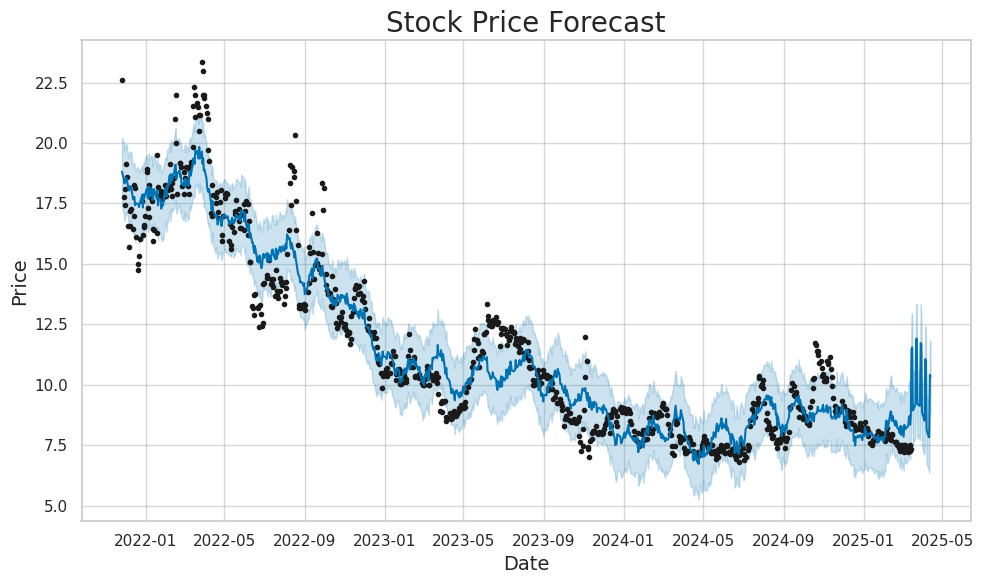

In [26]:
# Cell 3: Basic Prophet forecast visualization
fig = model.plot(forecast)
plt.title('Stock Price Forecast', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
# Cell 4: Interactive Plotly visualization
import plotly.graph_objects as go  # Add this import
from prophet.plot import plot_plotly

fig = plot_plotly(model, forecast)
fig.update_layout(
    title='Interactive Stock Price Forecast',
    yaxis_title='Price',
    xaxis_title='Date',
    hovermode='x unified',
    template='plotly_white'
)
fig.show()

NameError: name 'go' is not defined

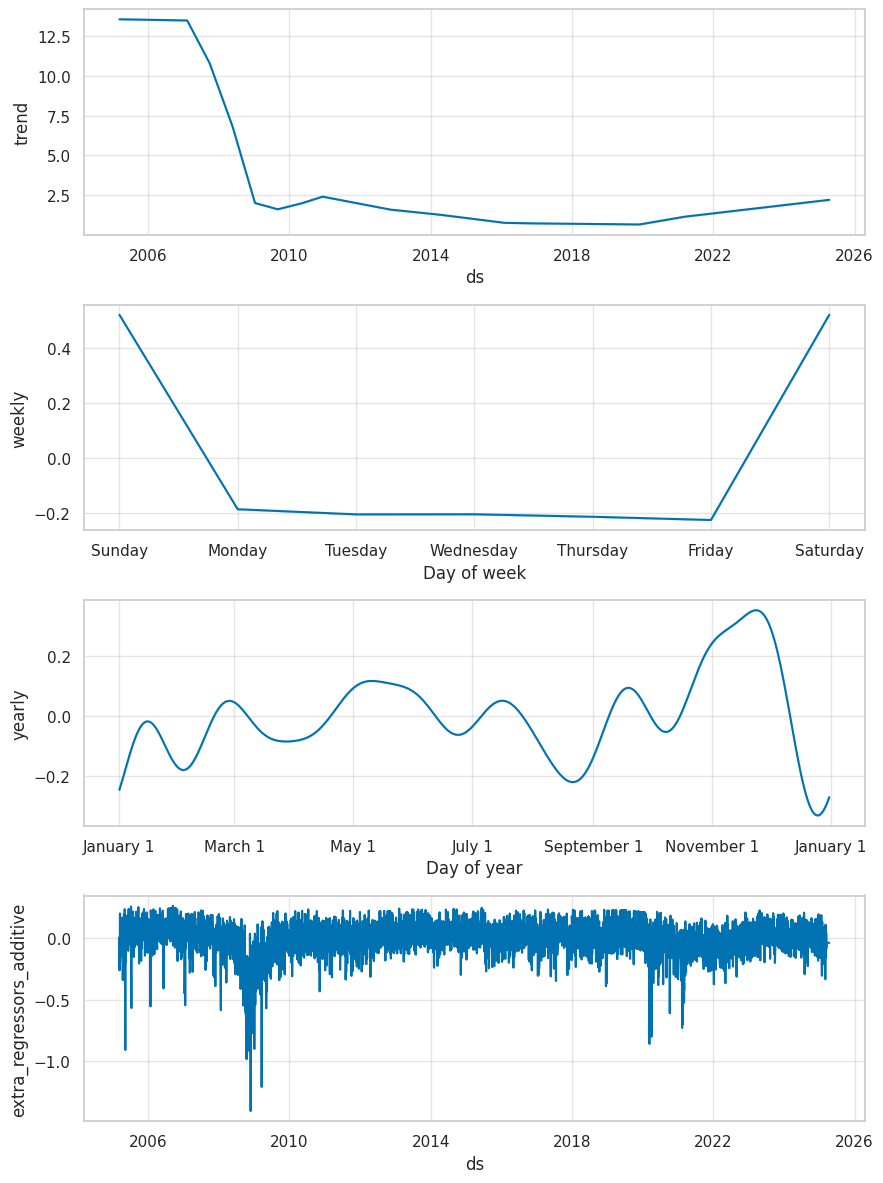

In [56]:
# Cell 5: Component visualization (trend, seasonality, etc.)
fig = model.plot_components(forecast)
plt.tight_layout()
plt.show()

In [57]:
# Cell 7: Actual vs Predicted comparison
# Merge actual data with forecast for comparison
actuals = prophet_ready_data[['ds', 'y']].copy()
comparison = pd.merge(
    actuals, 
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
    on='ds', 
    how='inner'
)

# Calculate error metrics on the training data
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
mape = np.mean(np.abs((comparison['y'] - comparison['yhat']) / comparison['y'])) * 100

print(f"Model Performance Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

Model Performance Metrics:
MAE: 0.4855
RMSE: 0.9683
MAPE: 25.89%


In [18]:
12*1.15

13.799999999999999

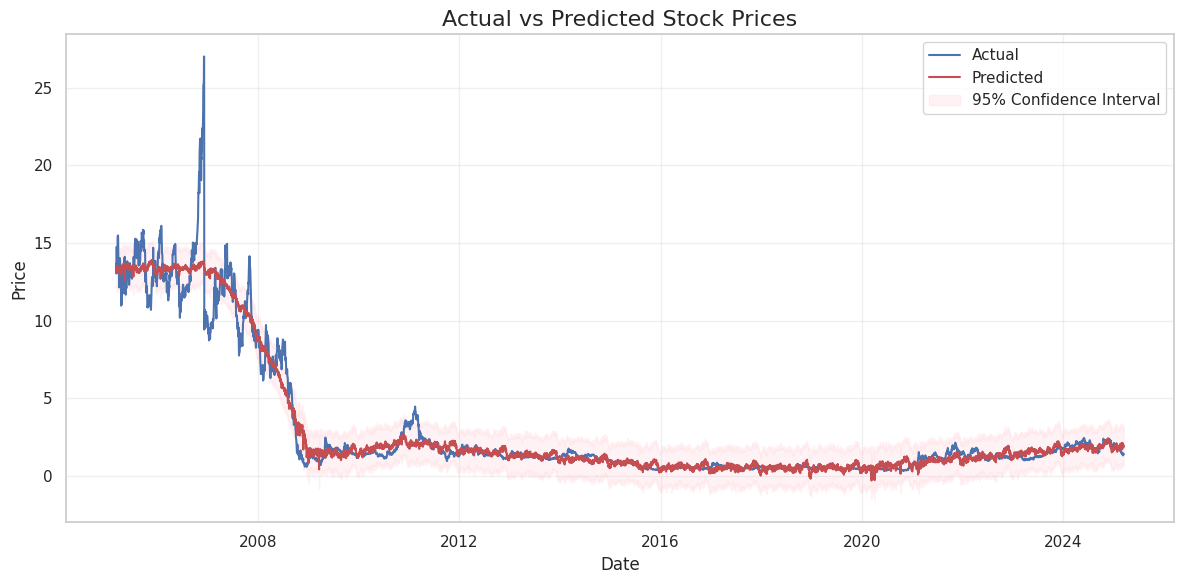

In [58]:
# Cell 8: Visualize actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(comparison['ds'], comparison['y'], 'b-', label='Actual')
plt.plot(comparison['ds'], comparison['yhat'], 'r-', label='Predicted')
plt.fill_between(comparison['ds'], comparison['yhat_lower'], comparison['yhat_upper'], 
                 color='pink', alpha=0.2, label='95% Confidence Interval')
plt.title('Actual vs Predicted Stock Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

KeyError: 'rsi_14'

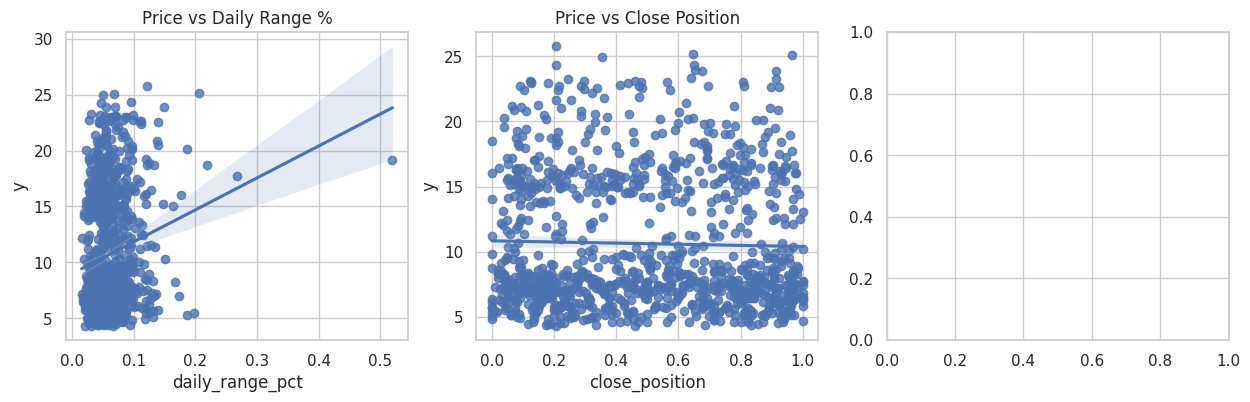

In [20]:
# Cell 9: Visualization for feature importance
# For each regressor, we can plot the trend to see its impact
if 'daily_range_pct' in prophet_ready_data.columns:
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    sns.regplot(x=prophet_ready_data['daily_range_pct'], y=prophet_ready_data['y'])
    plt.title('Price vs Daily Range %')
    
    plt.subplot(1, 3, 2)
    sns.regplot(x=prophet_ready_data['close_position'], y=prophet_ready_data['y'])
    plt.title('Price vs Close Position')
    
    plt.subplot(1, 3, 3)
    sns.regplot(x=prophet_ready_data['rsi_14'], y=prophet_ready_data['y'])
    plt.title('Price vs RSI(14)')
    
    plt.tight_layout()
    plt.show()

In [21]:
# Cell 10: Interactive time series dashboard with Plotly
def create_stock_dashboard(data, forecast):
    # Create a figure with subplots
    fig = go.Figure()
    
    # Add actual price trace
    fig.add_trace(go.Scatter(
        x=data['ds'],
        y=data['y'],
        mode='lines',
        name='Actual',
        line=dict(color='blue')
    ))
    
    # Add predicted price trace
    fig.add_trace(go.Scatter(
        x=forecast['ds'],
        y=forecast['yhat'],
        mode='lines',
        name='Forecast',
        line=dict(color='red')
    ))
    
    # Add confidence interval
    fig.add_trace(go.Scatter(
        x=forecast['ds'].tolist() + forecast['ds'].tolist()[::-1],
        y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'].tolist()[::-1],
        fill='toself',
        fillcolor='rgba(231,107,243,0.1)',
        line=dict(color='rgba(255,255,255,0)'),
        name='Confidence Interval'
    ))
    
    # Update layout
    fig.update_layout(
        title='Stock Price Forecast Dashboard',
        yaxis_title='Price',
        xaxis_title='Date',
        hovermode='x unified',
        template='plotly_white',
        height=600
    )
    
    # Add range slider
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date"
        )
    )
    
    return fig

# Create and display the dashboard
dashboard = create_stock_dashboard(prophet_ready_data, forecast)
dashboard.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

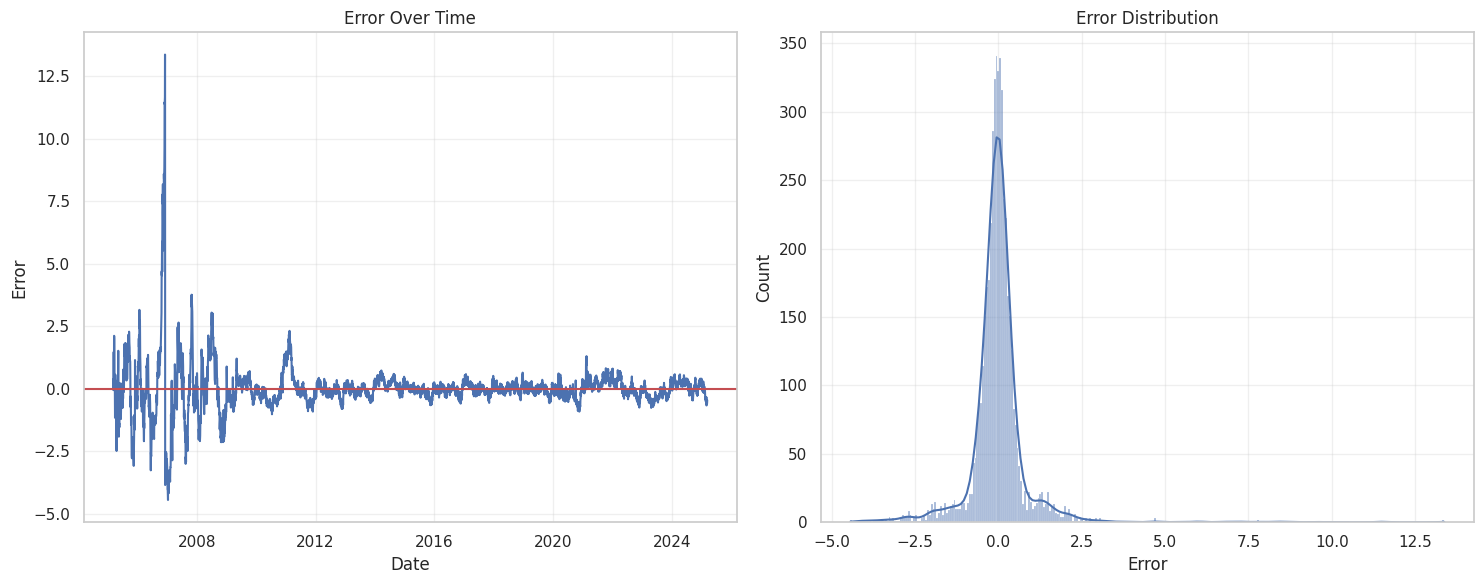

In [59]:
# Cell 11: Forecast error analysis
comparison['error'] = comparison['y'] - comparison['yhat']
comparison['percentage_error'] = (comparison['error'] / comparison['y']) * 100

plt.figure(figsize=(15, 6))

# Error over time
plt.subplot(1, 2, 1)
plt.plot(comparison['ds'], comparison['error'])
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Error Over Time')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)

# Error distribution
plt.subplot(1, 2, 2)
sns.histplot(comparison['error'], kde=True)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

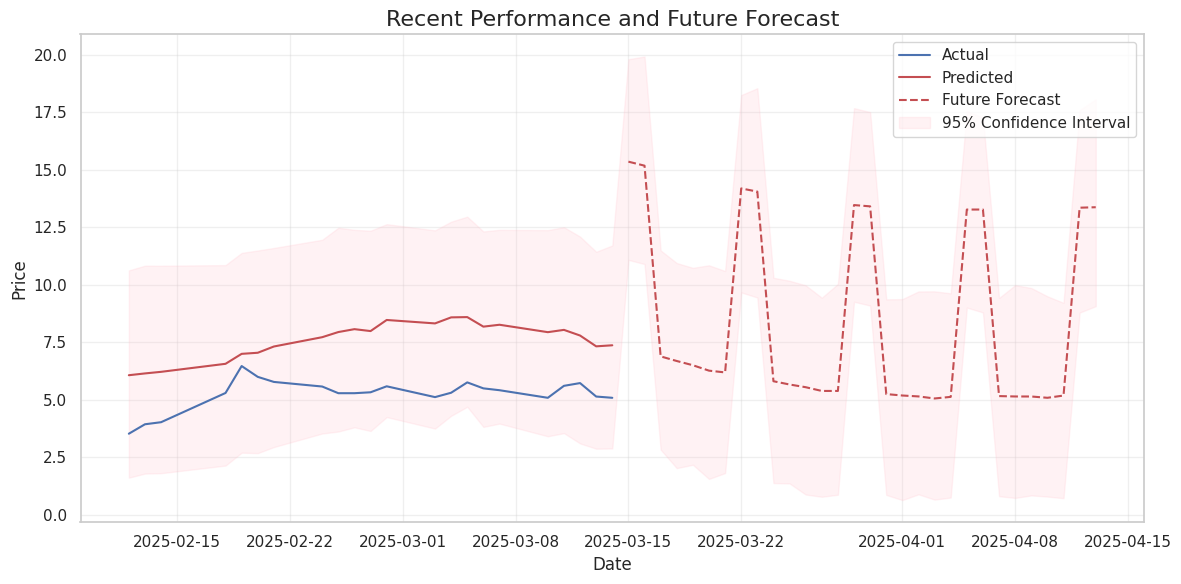

In [47]:
# Cell 12: Recent performance and future predictions
# Get the last 30 days of actuals and the next 30 days of predictions
recent_past = 30
future_forecast = 30

last_date = prophet_ready_data['ds'].max()
recent_comparison = comparison[comparison['ds'] >= (last_date - pd.Timedelta(days=recent_past))]
future_only = forecast[(forecast['ds'] > last_date) & (forecast['ds'] <= (last_date + pd.Timedelta(days=future_forecast)))]

plt.figure(figsize=(12, 6))
plt.plot(recent_comparison['ds'], recent_comparison['y'], 'b-', label='Actual')
plt.plot(recent_comparison['ds'], recent_comparison['yhat'], 'r-', label='Predicted')
plt.plot(future_only['ds'], future_only['yhat'], 'r--', label='Future Forecast')
plt.fill_between(
    pd.concat([recent_comparison['ds'], future_only['ds']]), 
    pd.concat([recent_comparison['yhat_lower'], future_only['yhat_lower']]),
    pd.concat([recent_comparison['yhat_upper'], future_only['yhat_upper']]),
    color='pink', alpha=0.2, label='95% Confidence Interval'
)
plt.title('Recent Performance and Future Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
df

Date   Open     High      Low  Close    Volume
0     2020-11-30  11.00  13.9400  10.1000  10.48    186696
1     2020-12-01  10.60  10.7400  10.4600  10.60    435476
2     2020-12-02  10.65  10.7050  10.4000  10.55    318208
3     2020-12-03  10.55  10.5600  10.4000  10.42    448261
4     2020-12-04  10.65  10.6500  10.3700  10.41    536546
...          ...    ...      ...      ...    ...       ...
1072  2025-03-10  12.07  12.1700  10.9300  11.18  69934329
1073  2025-03-11  11.06  11.4967  10.8503  11.26  54907858
1074  2025-03-12  11.86  12.1200  11.4400  11.92  54143684
1075  2025-03-13  12.00  12.0900  11.3100  11.39  38157650
1076  2025-03-14  11.69  12.1200  11.6100  12.09  37188180

[1077 rows x 6 columns]

In [60]:
# Generate a 6-month future forecast
# Create a future dataframe for 180 days (approximately 6 months)
future_6m = model.make_future_dataframe(periods=180)

# Add required regressor values to the future dataframe
recent_data = prophet_ready_data.iloc[-30:]  # Use last 30 days for regressor values

for feature in ['daily_range_pct', 'close_position']:
    # Set future values to the mean of recent values
    future_6m[feature] = np.nan
    
    # For historical dates, use actual values
    historical_values = prophet_ready_data.set_index('ds')[feature]
    future_6m.loc[future_6m['ds'].isin(prophet_ready_data['ds']), feature] = \
        future_6m.loc[future_6m['ds'].isin(prophet_ready_data['ds']), 'ds'].map(historical_values)
    
    # For future dates, use the mean of recent values
    future_6m.loc[~future_6m['ds'].isin(prophet_ready_data['ds']), feature] = recent_data[feature].mean()

# Generate the 6-month forecast
forecast_6m = model.predict(future_6m)

# Display the forecast summary
forecast_end = forecast_6m['ds'].max().strftime('%Y-%m-%d')
print(f"Forecast generated through: {forecast_end}")
print(f"Final predicted price: ${forecast_6m['yhat'].iloc[-1]:.2f}")
print(f"Range: ${forecast_6m['yhat_lower'].iloc[-1]:.2f} to ${forecast_6m['yhat_upper'].iloc[-1]:.2f}")

Forecast generated through: 2025-09-10
Final predicted price: $2.09
Range: $0.86 to $3.38


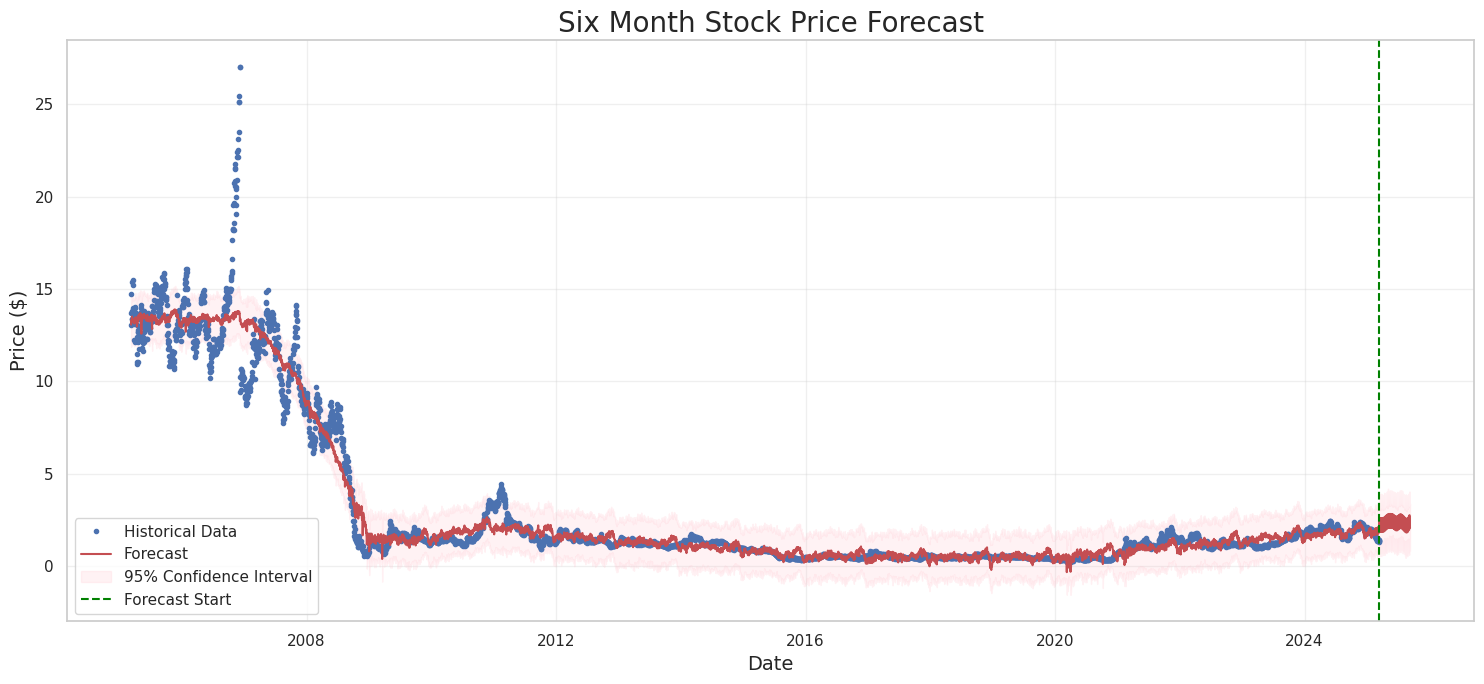

In [61]:
# Basic 6-month forecast visualization
plt.figure(figsize=(15, 7))
plt.plot(prophet_ready_data['ds'], prophet_ready_data['y'], 'b.', label='Historical Data')
plt.plot(forecast_6m['ds'], forecast_6m['yhat'], 'r-', label='Forecast')
plt.fill_between(forecast_6m['ds'], forecast_6m['yhat_lower'], forecast_6m['yhat_upper'], 
                color='pink', alpha=0.2, label='95% Confidence Interval')

# Add a vertical line to indicate where historical data ends
last_date = prophet_ready_data['ds'].max()
plt.axvline(x=last_date, color='green', linestyle='--', label='Forecast Start')

# Add annotations
plt.title('Six Month Stock Price Forecast', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

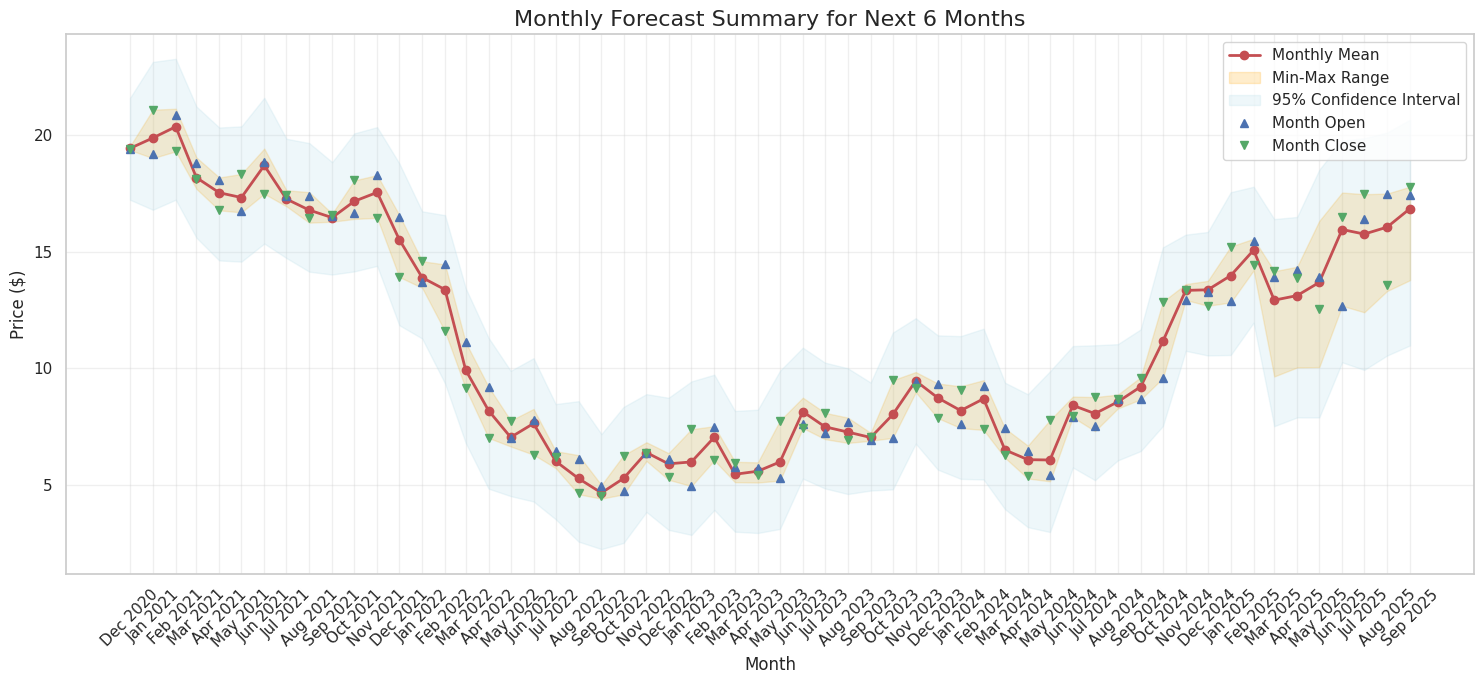

In [29]:
# Monthly forecast summary visualization (aggregated by month)
# Extract year and month from the forecast dates
forecast_6m['year_month'] = forecast_6m['ds'].dt.to_period('M')

# Group by month and calculate monthly stats
monthly_forecast = forecast_6m.groupby('year_month').agg({
    'yhat': ['mean', 'first', 'last', 'min', 'max'],
    'yhat_lower': 'min',
    'yhat_upper': 'max'
}).reset_index()

# Flatten the MultiIndex columns
monthly_forecast.columns = ['_'.join(col).strip('_') for col in monthly_forecast.columns.values]

# Convert period to datetime for plotting
monthly_forecast['month'] = monthly_forecast['year_month'].dt.to_timestamp()

# Create a monthly summary plot
plt.figure(figsize=(15, 7))

# Plot the monthly mean forecast
plt.plot(monthly_forecast['month'], monthly_forecast['yhat_mean'], 'ro-', linewidth=2, label='Monthly Mean')

# Plot the range from min to max
plt.fill_between(monthly_forecast['month'], monthly_forecast['yhat_min'], 
                monthly_forecast['yhat_max'], color='orange', alpha=0.2, label='Min-Max Range')

# Plot the confidence interval
plt.fill_between(monthly_forecast['month'], monthly_forecast['yhat_lower_min'], 
                monthly_forecast['yhat_upper_max'], color='lightblue', alpha=0.2, label='95% Confidence Interval')

# Add month start and end points
plt.plot(monthly_forecast['month'], monthly_forecast['yhat_first'], 'b^', label='Month Open')
plt.plot(monthly_forecast['month'], monthly_forecast['yhat_last'], 'gv', label='Month Close')

# Add labels and title
plt.title('Monthly Forecast Summary for Next 6 Months', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

# Format x-axis to show month names
plt.xticks(monthly_forecast['month'], monthly_forecast['month'].dt.strftime('%b %Y'), rotation=45)
plt.tight_layout()
plt.show()

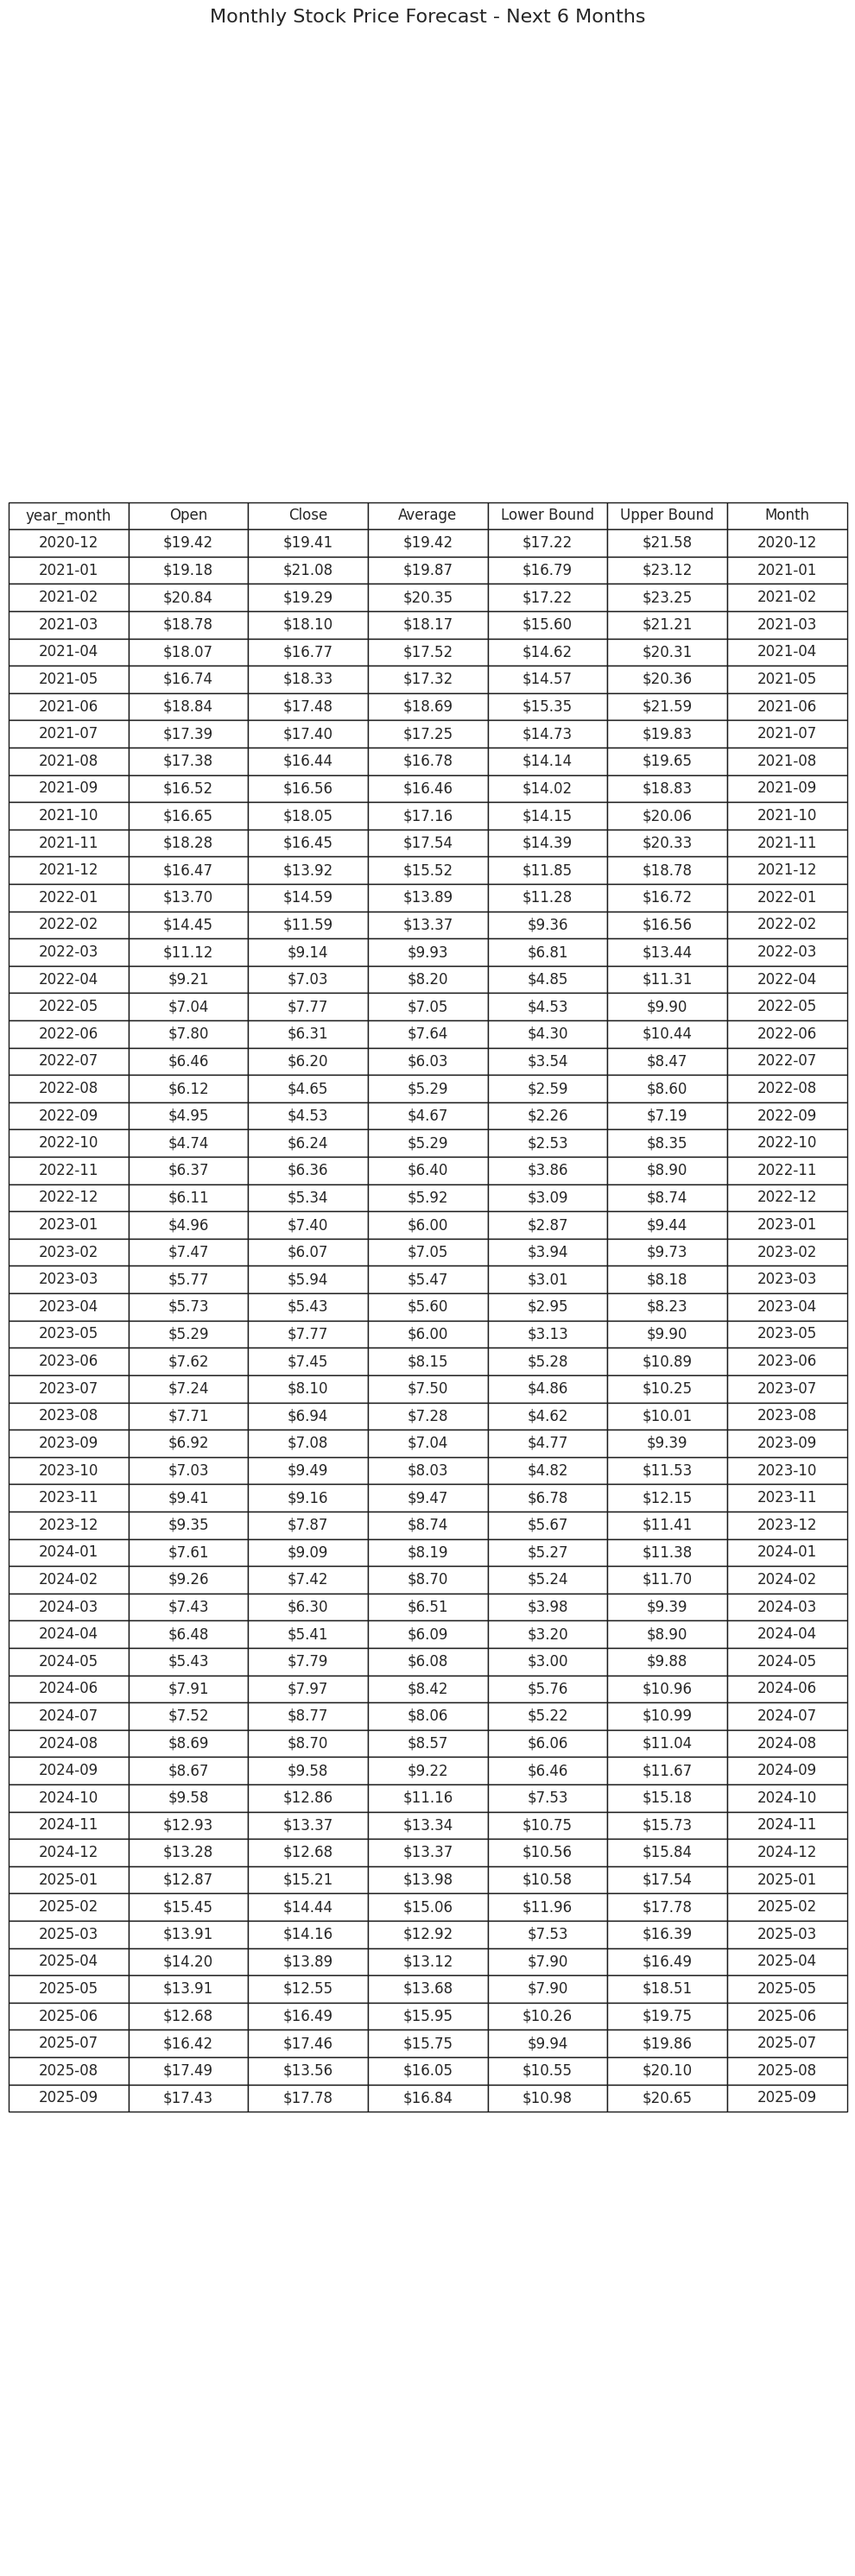

In [34]:
# Table of monthly predictions for the next 6 months
from matplotlib.table import Table

# Prepare data for the table
table_data = monthly_forecast[['year_month', 'yhat_first', 'yhat_last', 'yhat_mean', 'yhat_lower_min', 'yhat_upper_max']]
table_data = table_data.rename(columns={
    'year_month_': 'Month',
    'yhat_first': 'Open',
    'yhat_last': 'Close',
    'yhat_mean': 'Average',
    'yhat_lower_min': 'Lower Bound',
    'yhat_upper_max': 'Upper Bound'
})

# Convert to string format with dollar signs and two decimal places
for col in ['Open', 'Close', 'Average', 'Lower Bound', 'Upper Bound']:
    table_data[col] = table_data[col].apply(lambda x: f"${x:.2f}")

# Convert Period to string for the month
table_data['Month'] = table_data['year_month'].astype(str)

# Create figure and axis for the table
fig, ax = plt.subplots(figsize=(10, len(table_data) * 0.5 + 1))
ax.axis('off')
ax.axis('tight')

# Create the table
table = ax.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    loc='center',
    cellLoc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)

# Add a title
plt.title('Monthly Stock Price Forecast - Next 6 Months', fontsize=16, pad=20)
plt.tight_layout()
plt.show()